# <div align="center">Reducing Emissions in Car Carriers <br> Exploring Sustainable Solutions</div>


In [19]:
import librosa
import librosa.display
from IPython.display import Audio

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial
import shutil
import os
import pickle

from idling_detection_functions import *


Define 4 variables containing the following paths: 
- path to the UrbanSound8k.csv file, a file containing all metadata for the dataset
- path to the unzipped keggle dataset containing 10 folders with all sound files from the dataset
- path to wav, an empty folder where the dataset created in this notebook will be stored
- path to png, an empty folder where all spectrums created later on will be stored

In [11]:
#Giacomos paths
#csv containing the labels
us_file = '/Users/giacomo/Documents/lavoro/sound8k_data/UrbanSound8K.csv'
#the keggle dataset
path_keggle_dataset = '/Users/giacomo/Documents/lavoro/sound8k_data/keggle_dataset/'

#wav and png datasets
path_to_wav = '/Users/giacomo/Documents/lavoro/sound8k_data/our_dataset/'

path_to_png = '/Users/giacomo/Documents/lavoro/sound8k_data/mel_specs/'

In [2]:
#Matthias paths
#csv containing the labels
us_file = 'C:/Users/matthias/Documents/Projects/urban_sound_files/UrbanSound8K.csv'
#the keggle dataset
path_keggle_dataset = 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/'

#wav and png datasets
path_to_wav = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset/'
path_to_png = 'C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/'

# Dataset preparation

Create a dataframe from the urban sound 8K dataset that contains all engine idling sounds as well as an equal number of random sounds taken from the other categories. 


In [12]:
df = pd.read_csv(us_file)

# create a list of all files paths from the dataset within the subfolders 
sound_files = [os.path.join(root, file) for root, directories, files in os.walk(path_keggle_dataset) for file in files if file.endswith(".wav")]

# Create a dictionary mapping filenames to paths. A dictionary is needed to work correctly with the dataframe
file_path_dict = {os.path.basename(path): path for path in sound_files}

# Add a new column with the encoding details
df['encoding'] = df['slice_file_name'].apply(get_encoding, file_path_dict=file_path_dict)

# Keep only the rows with a known encoding

# keep only eingine idling values
df_engine = df.loc[(df['class'] == 'engine_idling') 
                   & (df['encoding'] != 'MS_ADPCM')
                   & (df['encoding'] != 'IMA_ADPCM')]

#pick the same amount of engine idling values from all other classes
df_non_engine = df.loc[(df['class'] != 'engine_idling')
                       & (df['encoding'] != 'MS_ADPCM')
                       & (df['encoding'] != 'IMA_ADPCM')].sample(len(df_engine), random_state=33)
# rename the different classes to non_engine_idling
df_non_engine.loc[df_non_engine['class'] != 'engine_idling', 'class'] = 'non_engine_idling'

#put the two dataframes together
df_training = pd.concat([df_non_engine, df_engine])

#create a list with all filenames from the dataframe 
file_list = df_training['slice_file_name'].tolist()

In [13]:
# Now copy all files present in the two lists (list of all full paths and list of files we want to use) 
# into a new folder (destination folder path defined above)

for path in sound_files:
    filename = os.path.basename(path)
    if filename in (file_list):
        destination = os.path.join(path_to_wav, filename)
        shutil.copy2(path, path_to_wav)

## Standardize imput 


Some files are recorded with one, some with two channels. Lets convert all files to two channels.
Also, some have a sampling rate of 48.000 Hz, some of 44.100 Hz. Here we need to make all imput arrays the smaller size.
Last we make all files the same length by adding silence to the end of shorter files and make them all as long as the longest file.

In [5]:

# get full path of the audio files
full_file_paths = [os.path.join(path_to_wav, filename) 
                   for filename in os.listdir(path_to_wav) 
                   if os.path.isfile(os.path.join(path_to_wav, filename)) and filename.endswith('.wav')] 

# find max duration in ms within all audio files        
durations = []
for file in full_file_paths:
    if not file.endswith('.wav'):
        continue
    try:
        durations.append(librosa.get_duration(path=file))
    except Exception as e:
        print(f"Error with file {file}: {e}")

target_length = max(durations) * 1000 

# loop trough all files and apply the standardization
for file in full_file_paths:
    if not file.endswith('.wav'):
        continue
    try:
        #standardize al files to 44100 Hz and Mono as well as make them all the same length
        standardize_audio(file, target_length, samp_rate=44100, channels=True)
    except Exception as e:
        print(f"Error with file {file}: {e}")

## Data augmentation

To increase the size of our dataset we decided to augment the data we have by creating time shifted versions of our audios. 

In [5]:
# Create a new partial function with 'output_dir' pre-filled
timeshift_partial = partial(time_shift, output_dir=path_to_wav, shift_max=1)

# Create a pool of workers and apply 'time_shift_partial' function to each file
with Pool() as pool:
    pool.map(timeshift_partial, full_file_paths)

# We now want to add the augmented files to this dataframe. In order to attach the correct label to them
# we concatenate two identical dataframes, with one having the .wav ending and the other the _aug.wav ending. 
# This way we assign the correct labels to the _aug.wav files

def add_augmentation(row):
    row['slice_file_name'] = row['slice_file_name'].replace('.wav', '_aug.wav')
    return row

# Apply the function and concatenate the results
df_train_augmented = pd.concat([df_training, df_training.apply(add_augmentation, axis=1)], ignore_index=True)

print(df_train_augmented['class'].value_counts())

## Create mel spectrograms

First we check one of the samples to get a general idea of what the audio looks like. We also directly compare it to a time shifted file. We take a look at a waveplot as well as a mel spectrogram.
After that we will create mel spectrograms for each audio file.

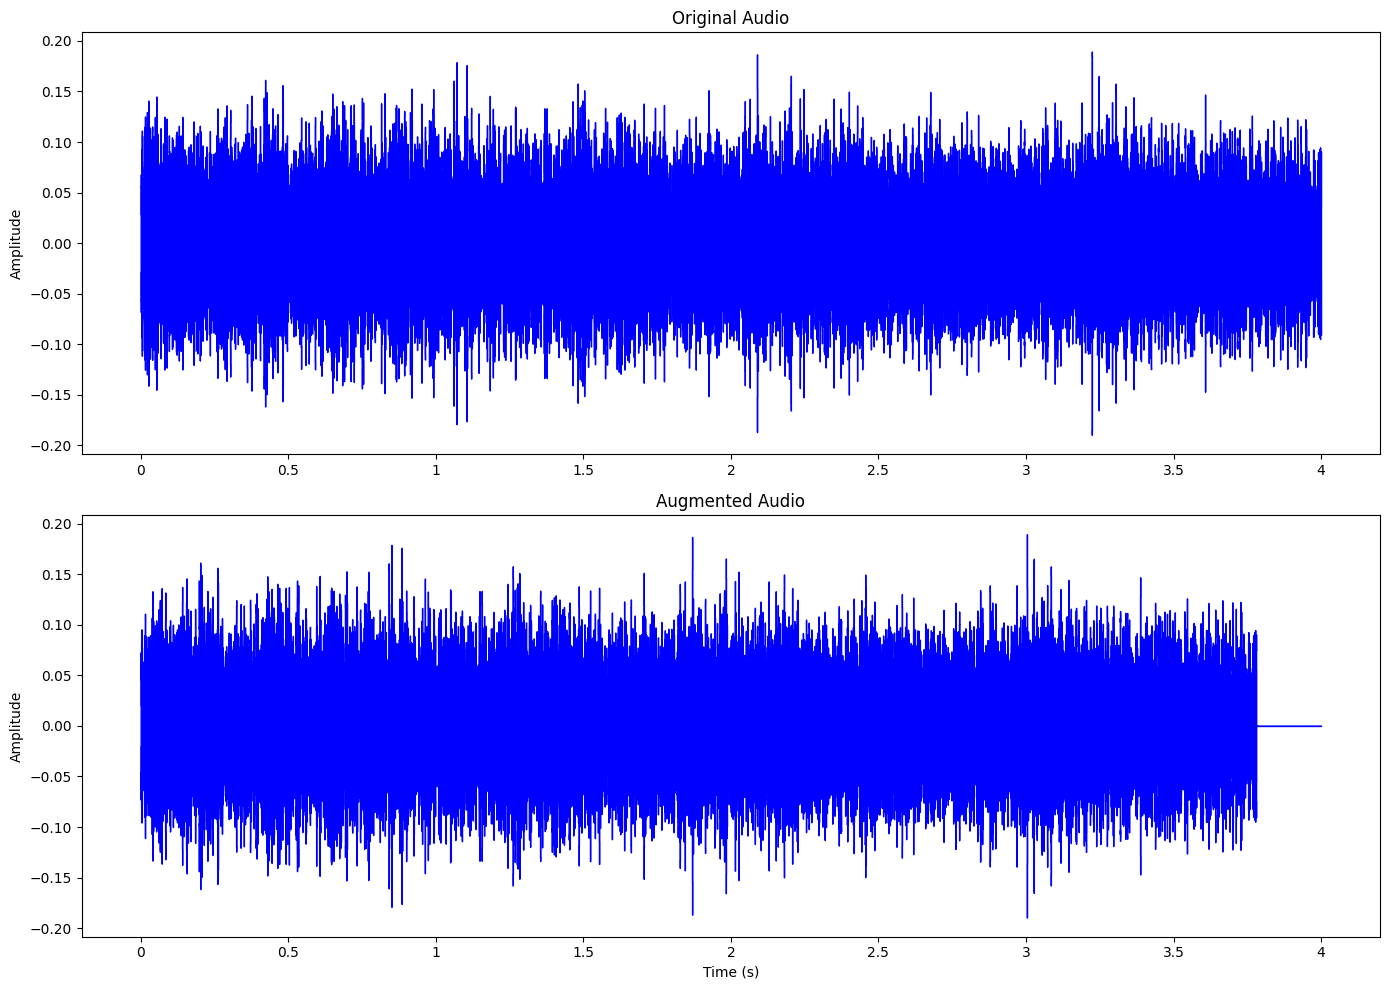

In [78]:
# select an audio file as an example as well as its augmented version to see the difference
audio_file =  path_to_wav  + '94632-5-1-9.wav'
audio_file_aug = path_to_wav + '94632-5-1-9_aug.wav'

#If samples are not already, convert to np.array, can probably be simpflified, no need for if check
y, sr = librosa.load(audio_file, sr=44100, mono = True)
y_aug, sr_aug = librosa.load(audio_file_aug, sr=44100, mono = True)

if not isinstance(y, np.ndarray):
    samples = np.array(y)

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Original Audio')
plt.xlabel('')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_aug, sr=sr_aug, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Augmented Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [79]:
# Listen to the audio 
Audio(audio_file)

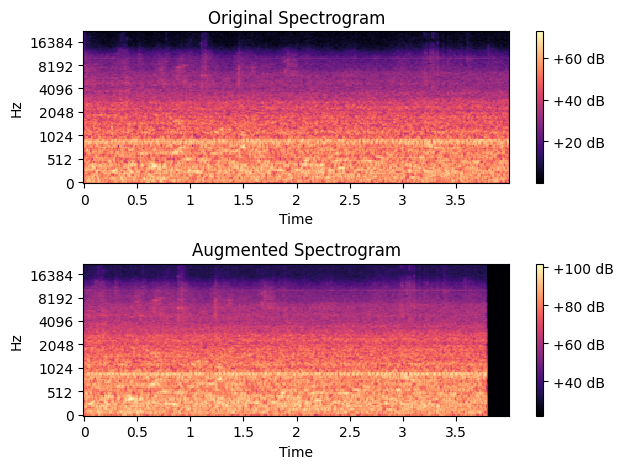

In [80]:

#Apply fourier transformation and plot 
sgram = librosa.stft(y)
sgram_aug = librosa.stft(y_aug)

# create mel spectrogram
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)

sgram_mag_aug, _ = librosa.magphase(sgram_aug)
mel_scale_sgram_aug = librosa.feature.melspectrogram(S=sgram_mag_aug, sr=sr_aug)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

mel_sgram_aug = librosa.amplitude_to_db(mel_scale_sgram_aug, ref=np.min)


plt.subplot(2, 1, 1)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Plot the second spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_sgram_aug, sr=sr_aug, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Augmented Spectrogram')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# create mel specs for all audio files in the dataset
create_mel_specs(path_to_wav, path_to_png)

# Create CNN and fully connected Layers

We first divide the dataset into a train, a validation and a test dataset. 

We then ran a search with different architectures (not shown here) followe by a random grid search for the most promising hyperparameters.

We then applied the results and hardcoded the definitive model. This includes 5 Convolutional layers, followed by a flatten layer and 3 dense layers. Loss and accuracy during training are plotted below. 

Last we tested our best performing the model on the test dataset.

In [50]:

# Preprocess and batch the dataset (add any necessary preprocessing here)
df_train_augmented.loc[:,'slice_file_name'] = df_train_augmented['slice_file_name'].str.replace('.wav', '.png')


# Split the data into train+validation and test sets
train_val_df, test_df = train_test_split(df_train_augmented, test_size=0.2, random_state=42)

# Further split the train+validation set into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create an ImageDataGenerator for data loading and preprocessing
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to the range [0, 1]
)

# Use flow_from_dataframe to load and preprocess the images
batch_size = 32  # Adjust this according to your needs

# Train generator
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=path_to_png,
    x_col="slice_file_name",  # Column containing filenames
    y_col="class",  # Column containing class labels
    target_size=(224, 224),  # Reshape your images to a desired size
    batch_size=batch_size,
    class_mode='categorical',  # If you have multiple classes
    validate_filenames=True  # For the training set
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    val_df,
    directory=path_to_png,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=True # For the validation set
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=path_to_png,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=True # For the test set
)

num_classes = len(train_generator.class_indices)  # Get the number of classes

Found 2400 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
#build the model for the hyperparameter tuning: this model has 5 convolutional layer and 3 dense layers. The search range is based on previous 
# experiences with other tested models

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=16, max_value=32, step=16), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.1, default=0.05, step=0.05)))

    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_3_filter', min_value=64, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_4_filter', min_value=128, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_5_filter', min_value=256, max_value=512, step=128), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_5', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(units=hp.Int('dense_2_units', min_value=256, max_value=512, step=128),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_2', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(2, activation='softmax'))
    
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay=hp.Float('decay', min_value=1e-6, max_value=1e-2, sampling='LOG'),
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='tuner_results',
    project_name='engine_idling'
)

tuner.search_space_summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)
 
tuner.results_summary()

In [51]:
# Get the best hyperparameters and build a model with the best hyperparameters

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

def build_best_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(units=192, activation='relu'))
    model.add(Dropout(rate=0.1))

    model.add(Dense(units=384, activation='relu'))
    model.add(Dropout(rate=0.2))

    model.add(Dense(2, activation='softmax'))
    
    optimizer = Adam(
        learning_rate=0.000595334580075522,
        decay=0.0007086137607026645,
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return model

# Build the model with the best hyperparameters
best_model = build_best_model()


# Train the model and save the history
history = best_model.fit(train_generator, 
                        validation_data=validation_generator, 
                        epochs=20, 
                        steps_per_epoch=len(train_generator), 
                        validation_steps=len(validation_generator))

# Save the history
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/20
75/75 [==============================] - 51s 669ms/step - loss: 0.6913 - accuracy: 0.5367 - val_loss: 0.6604 - val_accuracy: 0.5700
Epoch 2/20
75/75 [==============================] - 54s 716ms/step - loss: 0.6563 - accuracy: 0.5933 - val_loss: 0.6459 - val_accuracy: 0.6250
Epoch 3/20
75/75 [==============================] - 56s 752ms/step - loss: 0.6209 - accuracy: 0.6504 - val_loss: 0.6136 - val_accuracy: 0.6650
Epoch 4/20
75/75 [==============================] - 56s 751ms/step - loss: 0.5565 - accuracy: 0.7079 - val_loss: 0.4746 - val_accuracy: 0.7725
Epoch 5/20
75/75 [==============================] - 57s 755ms/step - loss: 0.4346 - accuracy: 0.7987 - val_loss: 0.3806 - val_accuracy: 0.8300
Epoch 6/20
75/75 [==============================] - 58s 769ms/step - loss: 0.3840 - accuracy: 0.8304 - val_loss: 0.3513 - val_accuracy: 0.8487
Epoch 7/20
75/75 [==============================] - 59s 792ms/step - loss: 0.3153 - accuracy: 0.8642 - val_loss: 0.2652 - val_accuracy: 0.8963

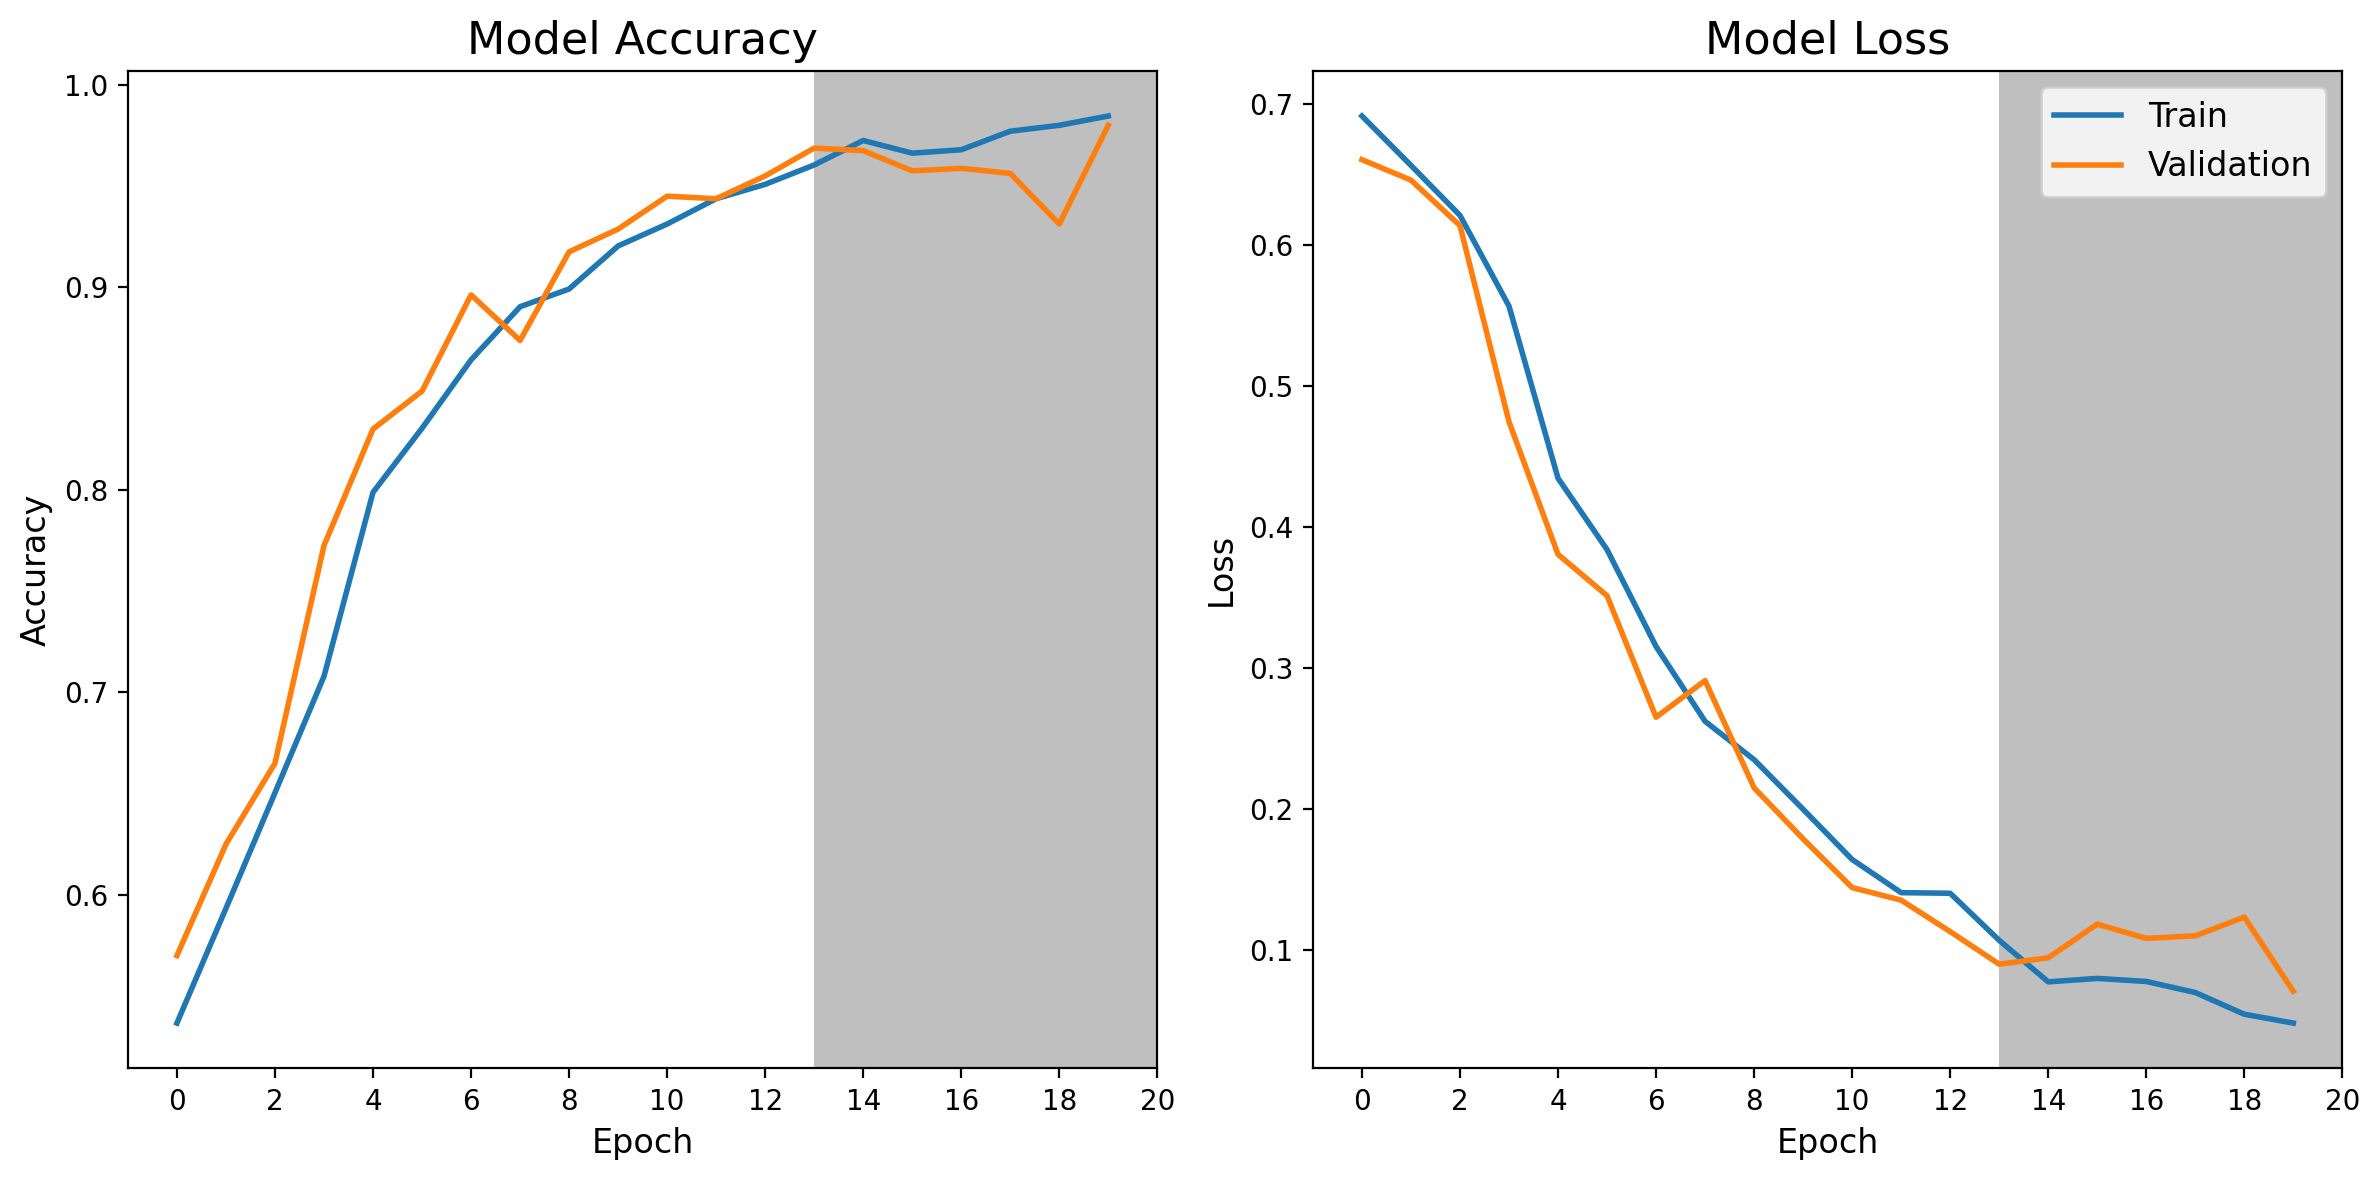

In [77]:
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], linewidth=2)
plt.plot(history['val_accuracy'], linewidth=2)
plt.xlim(-1, len(history['loss']))  # Set x-limits

plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
#plt.legend(['Train', 'Validation'], loc='lower right', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(np.arange(0, len(history['loss'])+2, step=2))
# Add shaded area from 14th epoch to the right
plt.axvspan(13, len(history['loss']), facecolor='gray', alpha=0.5)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], linewidth=2)
plt.plot(history['val_loss'], linewidth=2)
plt.xlim(-1, len(history['loss']))  # Set x-limits

plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(np.arange(0, len(history['loss'])+2, step=2))


# Add shaded area from 14th epoch to the right
plt.axvspan(13, len(history['loss']), facecolor='gray', alpha=0.5)

plt.tight_layout()

plt.show()

In [88]:
# create a new generator for prediction (without shuffling)
predict_generator = datagen.flow_from_dataframe(
    train_df,
    directory=path_to_png,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Keep data in same order
    validate_filenames=True
)

# Predict the values from the validation dataset
Y_pred = best_model.predict(predict_generator)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = predict_generator.classes

Found 2400 validated image filenames belonging to 2 classes.
75/75 [==============================] - 13s 170ms/step


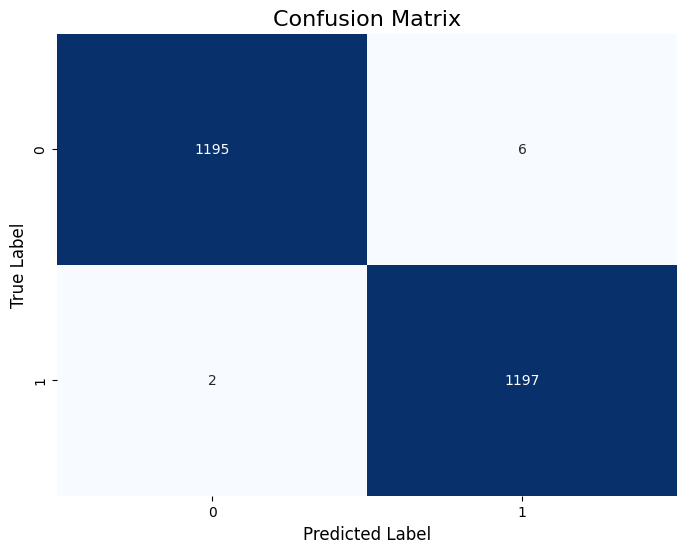

In [89]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [83]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

25/25 [==============================] - 4s 168ms/step - loss: 0.1055 - accuracy: 0.9712
Test Loss:  0.10552603006362915
Test Accuracy:  0.9712499976158142
